## Développement local avec Kubernetes

Dans ce guide, vous apprendrez à définir un cluster, à déployer tous les microservices en interaction et à travailler localement à des fins de développement. 

Nous nous appuierons sur les concepts introduits dans le guide précédent et nous décrirons comment configurer l'ensemble du système dans Kubernetes en termes pratiques, déployer plusieurs microservices et comment le faire fonctionner dans son ensemble sur votre propre ordinateur local. Ici, nous allons présenter les deux autres microservices : le frontend et le backend des utilisateurs. 

Nous verrons dans ce guide comment ils doivent être configurés pour fonctionner dans Kubernetes. Ceci s'ajoute au moteur de réflexion présenté au guide 2, Création d'un service REST avec Python ; guide 3, Créer, exécuter et tester votre service à l'aide de Docker et guide 4, Créer un pipeline et un workflow. Nous discuterons de la façon de les configurer correctement et d'ajouter d'autres options pour garantir leur bon fonctionnement une fois qu'ils sont déployés dans un environnement de production. 

Les sujets suivants seront traités dans ce guide.

* Mise en œuvre de plusieurs services
* Configuration des services
* Déploiement du système complet localement


À la fin du guide, vous disposerez d'un système Kubernetes local fonctionnel avec les trois microservices déployés et fonctionnant dans leur ensemble. Vous comprendrez comment fonctionnent les différents éléments et comment les configurer et les peaufiner

## Implémentation de plusieurs services

Dans le référentiel GitHub, vous pouvez trouver les trois microservices que nous utiliserons dans ce guide. Ils sont basés sur le monolithe présenté, et sont divisés en trois éléments :


* Thoughts Backend : comme décrit dans le guide précédent, il gère le stockage des pensées et leur recherche.

* Users Backend : cela stocke les utilisateurs et leur permet de se connecter. Sur la base de la description de la méthode d'authentification, cela crée un jeton qui peut être utilisé pour s'authentifier par rapport à d'autres systèmes

* Frontend : cela vient du monolithe, mais au lieu d'accéder directement à une base de données, il demande à l'utilisateur et au backend de pensées de répliquer la fonctionnalité.


Les services susmentionnés sont dockerisés de la même manière que le backend de pensées dans le guide 3, Construire, exécuter et tester votre service à l'aide de Docker. Regardons quelques-uns des détails pour les autres microservices

## Description du microservice Users Backend

Le code du Users Backend est disponible sur users_backend. La structure est très similaire à celle de Thoughts Backend, une application Flask-RESTPlus qui communique avec une base de données PostgreSQL. Elle a deux points de terminaison, comme le montre son interface Swagger


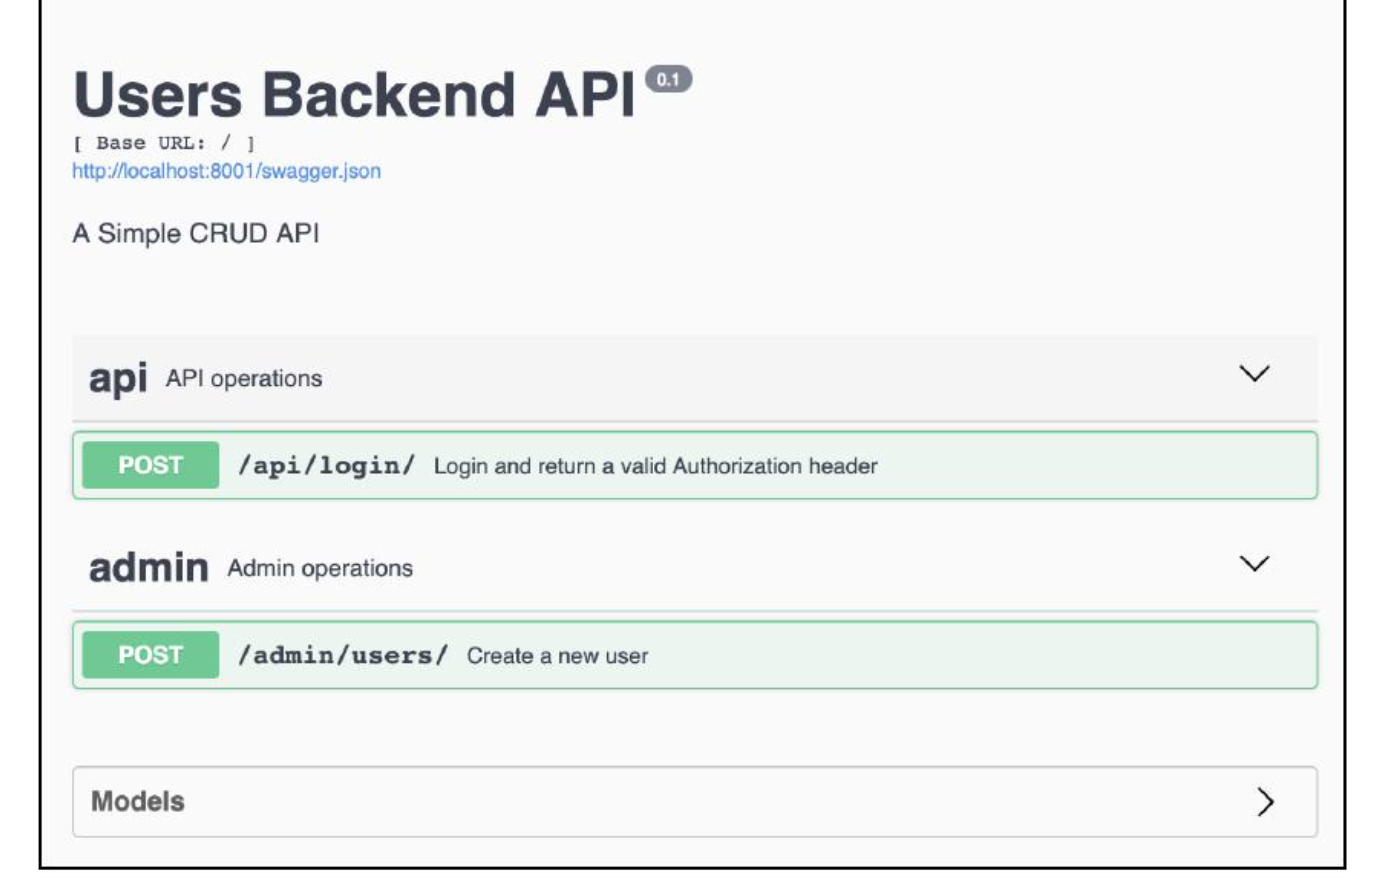

Les points finaux sont les suivants:
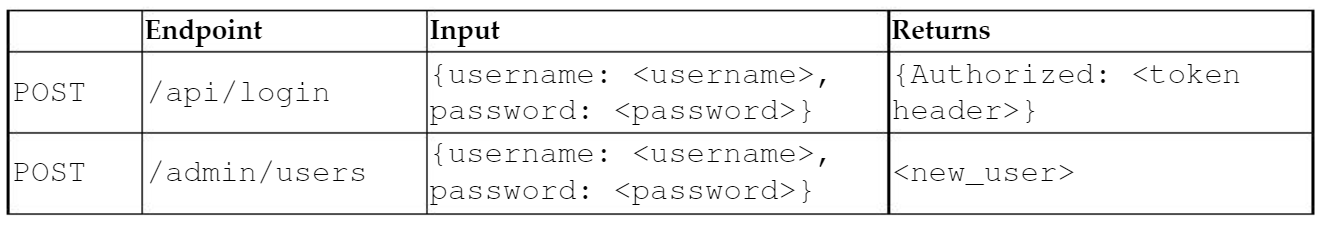

Le point de terminaison admin vous permet de créer de nouveaux utilisateurs et l'API de connexion renvoie un en-tête valide qui peut être utilisé pour le backend de pensées. Les utilisateurs sont stockés dans la base de données avec le schéma suivant#

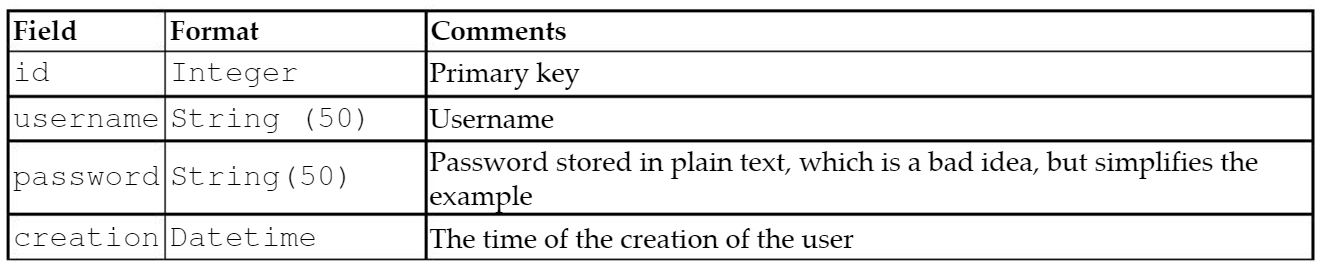

Ce schéma, dans la définition du modèle SQLAlchemy, est décrit à l'aide du code suivant 


    from sqlalchemy import func
    from users_backend.db import db


    class UserModel(db.Model):
        id = db.Column(db.Integer, primary_key=True)
        username = db.Column(db.String(50))
        # DO NOT EVER STORE PLAIN PASSWORDS IN DATABASES
        # THIS IS AN EXAMPLE!!!!!
        password = db.Column(db.String(50))
        creation = db.Column(db.DateTime, server_default=func.now())


Les utilisateurs bruce et stephen sont ajoutés à l'exemple de base de données comme moyen d'avoir des données d'exemple

## Description du microservice Frontend

Le code Frontend est disponible dans le référentiel GitHub. Il est basé sur le monolithe Django  Monolith 

La principale différence avec le monolithe est que la base de données n'est pas accessible. Par conséquent, il n'y a aucune utilisation pour l'ORM Django. Ils sont remplacés par des requêtes HTTP vers les autres backends. Pour faire les demandes, nous utilisons la bibliothèque de demandes fantastique


Par exemple, le fichier search.py ​​est converti dans le code suivant, qui délègue la recherche au microservice Thoughts Backend. Notez comment la requête du client est transformée en un appel d'API interne au point de terminaison GET /api/thoughts. Le résultat est décodé en JSON et rendu dans le modèle :




    import requests
    import math
    from django.conf import settings
    from django.shortcuts import render, redirect

    from .thoughts import get_username_from_session


    def load(request):
        # Create a slow call
        math.factorial(50000)
        return redirect('index')


    def search(request):
        username = get_username_from_session(request)
        search_param = request.GET.get('search')

        url = settings.THOUGHTS_BACKEND + '/api/thoughts/'
        params = {
            'search': search_param,
        }
        result = requests.get(url, params=params)
        results = result.json()

        context = {
            'thoughts': results,
            'username': username,
        }

        return render(request, 'search.html', context)


L'URL racine THOUGTHS_BACKEND provient des paramètres, à la manière habituelle de Django. Cet exemple est simple car aucune authentification n'est impliquée. Les paramètres sont capturés à partir de l'interface utilisateur, puis acheminés vers le backend. La demande est correctement formatée à la fois vers le backend et une fois le résultat obtenu, puis rendue. C'est le cœur de deux microservices travaillant ensemble


Un cas plus intéressant est le list_thought  frontend/mythoughts/thoughts/thoughts.py#L18). Le code suivant répertorie les réflexions de l'utilisateur connecté :



    def list_thoughts(request):
        '''
        List the user's thoughts
        '''
        username = get_username_from_session(request)
        if not username:
            return redirect('login')

        url = settings.THOUGHTS_BACKEND + '/api/me/thoughts/'
        headers = {
            'Authorization': request.COOKIES.get('session'),
        }
        result = requests.get(url, headers=headers)
        if result.status_code != http.client.OK:
            return redirect('login')

        context = {
            'thoughts': result.json(),
            'username': username,
        }
        return render(request, 'list_thoughts.html', context)

Ici, avant de faire quoi que ce soit, nous devons vérifier si un utilisateur est connecté. Cela se fait dans l'appel get_username_from_session, qui renvoie le nom d'utilisateur ou None, s'il n'est pas connecté. S'il n'est pas connecté, le retour est redirigé à l'écran de connexion.

Comme ce point de terminaison nécessite une authentification, nous devons ajouter la session de l'utilisateur dans un en-tête d'autorisation à notre demande. La session de l'utilisateur peut être obtenue à partir du dictionnaire thequest.COOKIES.

Par mesure de sécurité, nous devons vérifier si le code d'état renvoyé par le backend est correct. Pour cet appel, tout code d'état résultant qui n'est pas un 200 (appel HTTP correct) produira une redirection vers la page de connexion


La fonction get_username_from_session encapsule un callto validate_token_header, le même que celui introduit dans le guide précédent




    def get_username_from_session(request):
        cookie_session = request.COOKIES.get('session')
        username = validate_token_header(cookie_session,
                                        settings.TOKENS_PUBLIC_KEY)
        if not username:
            return None

        return username

Le fichier de paramètres contient la clé publique requise pour décoder le jeton



Le fichier d'environnement doit spécifier où se trouvent les URL de base pour le backend des utilisateurs et le backend de pensées, pour pouvoir s'y connecter

## Connexion des services 

Il est possible de tester les services fonctionnant à l'unisson uniquement avec docker-compose. Vérifiez que les fichiers docker-compose.yaml dans le backend des utilisateurs et le backend de pensées exposent différents ports en externe.

Le backend de pensées expose le port 8000 et le backend des utilisateurs expose le port 8001. Cela permet au frontend de s'y connecter (et d'exposer le port 8002). Ce schéma montre comment ce système fonctionne :


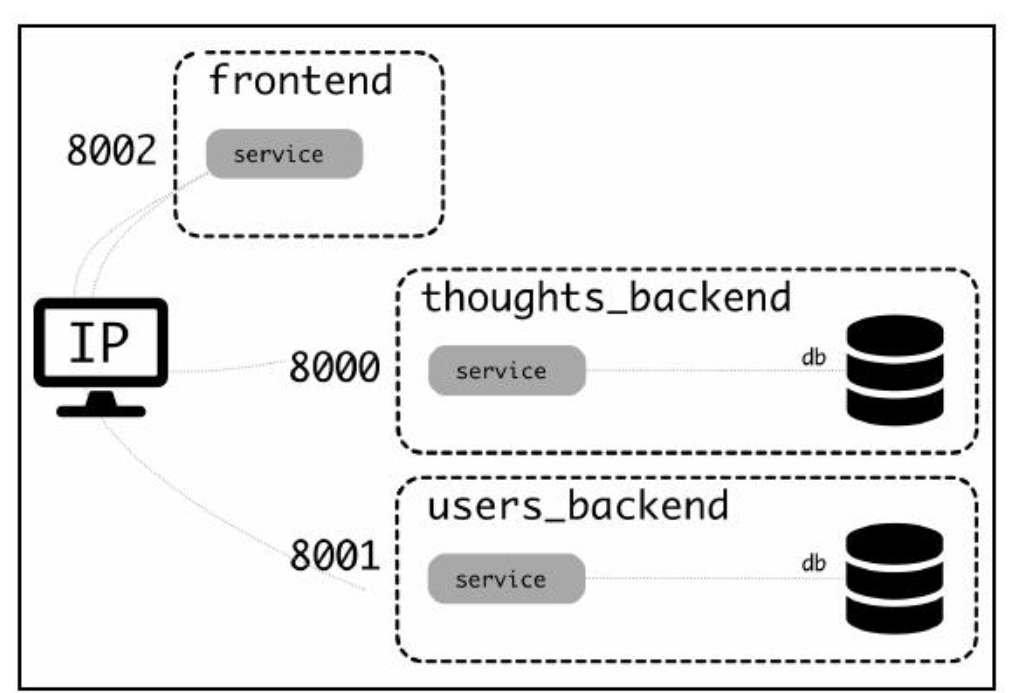

Vous pouvez voir comment les trois services sont isolés, car docker-compose créera son propre réseau pour qu'ils se connectent. Les deux backends ont leur propre conteneur, qui fait office de base de données.

Le service Frontend doit se connecter aux autres. L'URL des services doit être ajoutée au fichier environment.env et doit indiquer le service avec l'IP de l'ordinateur


    Une adresse IP interne telle que localhost ou 127.0.0.1 ne fonctionne pas,
    car elle est interprétée à l'intérieur du conteneur. Vous pouvez obtenir
    l'adresse IP locale en exécutant ifconfig.

Par exemple, si votre IP locale est 10.0.10.3, le fichier environment.env doit contenir les éléments suivants :


    THOUGHTS_BACKEND_URL=http://10.0.10.3:8000
    USER_BACKEND_URL=http://10.0.10.3:800

Si vous accédez au service Frontend dans votre navigateur, il doit se connecter aux autres services


Cette structure est un peu lourde, nous pouvons donc la transformer en un véritable cluster Kubernetes, visant le développement local.

## Configuration des services

Pour configurer les applications dans Kubernetes, nous devons définir les objets Kubernetes suivants par application :

* Deployment : le déploiement contrôlera la création des pods, ils seront donc toujours disponibles. Il les créera également en fonction de l'image et ajoutera une configuration, si nécessaire. Le pod exécute l'application


* Service : le service rendra les requêtes RESTful disponibles à l'intérieur du cluster, avec un nom court. Cela achemine les demandes vers n'importe quel pod disponible

* Ingress : cela rend le service disponible en dehors du cluster, afin que nous puissions accéder à l'application depuis l'extérieur du cluster


Dans cette section, nous examinerons en détail la configuration de Thoughts Backend à titre d'exemple. Plus tard, nous verrons comment les différentes parties se connectent. Nous avons créé un sous-répertoire Kubernetes thoughts_backend/kubernetes) pour stocker les fichiers .yaml avec chacune des définitions



Nous utiliserons l'exemple d'espace de noms, alors assurez-vous qu'il est créé :


    kubectl create namespace example




Commençons par le premier objet Kubernetes.



Configuration du déploiementPour le déploiement de Thoughts Backend, nous allons déployer un pod avec deux conteneurs, un avec la base de données et un autre avec l'application. Cette configuration facilite le travail en local mais gardez à l'esprit que recréer le pod redémarrera les deux conteneurs




Le fichier de configuration est entièrement disponible ici thoughts_backend/kubernetes/deployment.yaml), examinons donc ses différentes parties. Le premier élément décrit ce qu'il est et son nom, ainsi que l'espace de noms dans lequel il réside :




    ---
    apiVersion: apps/v1
    kind: Deployment
    metadata:
        name: thoughts-backend
        labels:
            app: thoughts-backend
        namespace: example


Ensuite, nous générons spec. Il contient le nombre de pods que nous devons conserver et le modèle pour chaque pod. le selector  définit les étiquettes qui sont surveillées et doit correspondre aux labels  du modèle :

  
    spec:
        replicas: 1
        selector:
            matchLabels:
                app: thoughts-backend

La section template définit les conteneurs dans sa propre section spec :

        template:
            metadata:
                labels:
                    app: thoughts-backend
            spec:
                containers:
                    - name: thoughts-backend-service
                      ....
                    
                    - name: thoughts-backend-db                  
                      ...



thoughts-backend-db est plus simple. Le seul élément requis est de définir le nom du conteneur et l'image. Nous devons définir la politique d'extraction sur Never  pour indiquer que l'image est disponible dans le référentiel Docker local et qu'il n'est pas nécessaire de l'extraire d'un registre distant.

  
                    - name: thoughts-backend-db
                      image: thoughts_backend_db:latest
                      imagePullPolicy: Never

Thoughts-backend-service doit définir le port exposé pour le service ainsi que les variables d'environnement. Les valeurs des variables sont celles que nous avons utilisées précédemment lors de la création de la base de données, à l'exception de POSTGRES_HOST, où nous avons l'avantage que tous les conteneurs du même pod partagent la même IP

                - name: thoughts-backend-service
                  image: thoughts_server:latest
                  imagePullPolicy: Never
                  ports:
                     - containerPort: 8000
                  env:
                      - name: DATABASE_ENGINE
                        value: POSTGRESQL
                      - name: POSTGRES_DB
                        value: thoughts
                      - name: POSTGRES_USER
                        value: postgres
                      - name: POSTGRES_PASSWORD
                        value: somepassword
                      - name: POSTGRES_PORT
                        value: "5432"
                      - name: POSTGRES_HOST
                        value: "127.0.0.1"


Pour obtenir le déploiement dans Kubernetes, vous devez appliquer le fichier, comme indiqué ici :



    $ kubectl apply -f thoughts_backend/kubernetes/deployment.yaml
    deployment "thoughts-backend" created


Le déploiement est maintenant créé dans le cluster :


    $ kubectl get deployments -n example
    NAME             DESIRED CURRENT UP-TO-DATE AVAILABLE AGE
    thoughts-backend 1       1       1          1         20s



Cela crée des pods automatiquement. Si le pod est supprimé ou plante, le déploiement le redémarrera avec un nom différent :



    $ kubectl get pods -n example
    NAME                              READY STATUS  RESTARTS AGE
    thoughts-backend-6dd57f5486-l9tgg 2/2   Running 0        1m

Le déploiement suit la dernière image, mais il ne créera pas de nouveau pod à moins qu'il ne soit supprimé. Pour apporter des modifications, assurez-vous de supprimer le pod manuellement, après quoi il sera recréé :



    $ kubectl delete pod thoughts-backend-6dd57f5486-l9tgg -n example
    pod "thoughts-backend-6dd57f5486-l9tgg" deleted
    
    $ kubectl get pods -n example
    NAME                              READY STATUS  RESTARTS AGE
    thoughts-backend-6dd57f5486-nf2ds 2/2   Running 0        28s

L'application n'est toujours pas détectable à l'intérieur du cluster, à part la référence à son nom de pod spécifique, qui peut changer, nous devons donc créer un service pour cela.




## Configuration du service

Nous créons un service Kubernetes pour créer un nom pour l'application exposée par le déploiement créé. Le service peut être vérifié dans le fichier service.yaml. Nous allons jeter un coup d'oeil:



    ---
    apiVersion: v1
    kind: Service
    metadata:
        namespace: example
        labels:
            app: thoughts-service
        name: thoughts-service
    spec:
        ports:
            - name: thoughts-backend
              port: 80
              targetPort: 8000
        selector:
            app: thoughts-backend
        type: NodePort


Les données initiales sont similaires au déploiement. La section spec définit les ports ouverts, en acheminant l'accès au service sur le port 80 vers le port 8000 dans des conteneurs dans le thoughts-backend, le nom du déploiement. La partie selector  achemine toutes les requêtes vers n'importe quel pod correspondant.



Le type est NodePort pour autoriser l'accès depuis l'extérieur du cluster. Cela nous permet de vérifier qu'il fonctionne correctement, une fois que nous avons trouvé l'IP exposée en externe :


    $ kubectl apply -f kubernetes/service.yaml
    service "thoughts-service" configured


    $ kubectl get service -n example
    NAME CLUSTER-IP EXTERNAL-IP PORT(S) AGE
    thoughts-service 10.100.252.250 <nodes> 80:31600/TCP 1m


Nous pouvons accéder à l'arrière-plan de Thoughts Backend en accédant à localhost avec le pod décrit. Dans ce cas, http://127.0.0.1:31600 :



Le service nous donne un nom interne, mais si nous voulons contrôler la façon dont il est exposé en externe, nous devons configurer un Ingress.

## Configuration de l'entrée

Enfin, nous décrivons l'entrée dans ingress.yaml thoughts_backend/kubernetes/ingress.yaml. Le fichier est copié ici. Notez comment nous configurons les métadonnées pour qu'elles vivent dans l'espace de noms approprié :




    ---
    apiVersion: extensions/v1beta1
    kind: Ingress
    metadata:
        name: thoughts-backend-ingress
        namespace: example
    spec:
        rules:
            - host: thoughts.example.local
              http:
                paths:
                  - backend:
                      serviceName: thoughts-service
                      servicePort: 80
                    path: /



Cette entrée fera que le service sera exposé aux nœuds sur le port 80. Comme plusieurs services peuvent être exposés sur les mêmes nœuds, ils se distinguent par leur nom d'hôte, dans ce cas, ideas.example.local



Après avoir appliqué le service, nous pouvons essayer d'accéder à la page, mais, à moins d'adresser les appels vers le bon hôte, nous obtiendrons une erreur 404 :

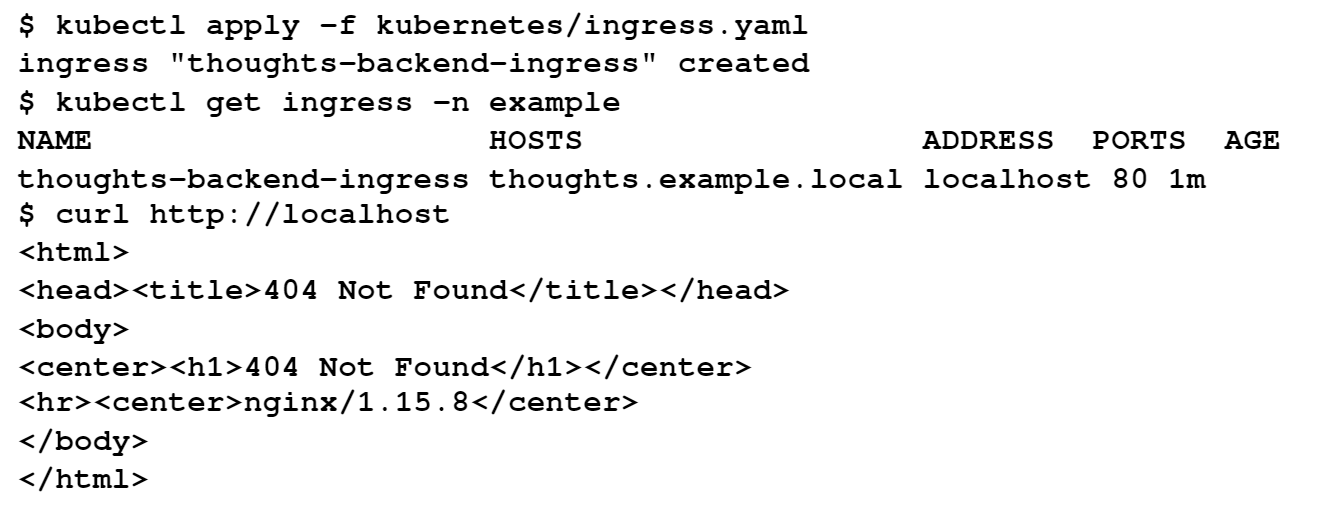

Nous devons être en mesure de diriger toute demande vers ideas.example.local vers notre hôte local. Sous Linux et macOS, le moyen le plus simple est de modifier votre fichier /etc/hosts pour inclure la ligne suivante :


    127.0.0.1 thoughts.example.local

Ensuite, nous pouvons utiliser un navigateur pour vérifier notre application, cette fois dans http://thoughts.example.local (et le port 80) :



La définition de différentes entrées d'hôte nous permet d'accéder à tous les services en externe, de pouvoir les modifier et de déboguer les problèmes. Nous définirons le reste des Ingresses de la même manière


    Si vous obtenez une erreur de connexion refusée et que le mot localhost
    n'apparaît pas lors de l'exécution de l'exemple kubectl get ingress -n, le
    contrôleur Ingress n'est pas installé dans votre installation Kubernetes.
    Vérifiez la documentation d'installation sur https://github.com/kubernetes/ingress-nginx/blob/master/docs/deploy/index.md. 
    

Nous avons donc maintenant une application fonctionnelle déployée localement dans Kubernetes !

## Déployer le système complet localement

Chacun de nos microservices fonctionne de manière autonome, mais pour que l'ensemble du système fonctionne, nous devions les déployer tous les trois (Thoughts Backend, Users Backend et Frontend) et les connecter les uns aux autres. 

Le Frontend, en particulier, nécessite que les deux autres microservices soient opérationnels. Avec Kubernetes, nous pouvons le déployer localement. Pour déployer le système complet, nous devons d'abord déployer le backend des utilisateurs, puis le frontend. Nous décrirons chacun de ces systèmes, en les mettant en relation avec le Thoughts Backend déjà déployé, que nous avons vu comment déployer auparavant.

## Déploiement du backend des utilisateurs 

Les fichiers du backend des utilisateurs sont très similaires au backend de pensées. Vous pouvez les vérifier dans le référentiel users_backend/kubernetes). Assurez-vous que les paramètres d'environnement dans les valeurs deployment.yaml sont corrects :



    $ kubectl apply -f users_backend/kubernetes/deployment.yaml
    deployment "users-backend" created
    
    $ kubectl apply -f users_backend/kubernetes/service.yaml
    service "users-service" created
    
    $ kubectl apply -f users_backend/kubernetes/ingress.yaml
    ingress "users-backend-ingress" created



N'oubliez pas d'inclure le nouveau nom d'hôte dans /etc/hosts:

    
    127.0.0.1 users.example.local 


Vous pouvez accéder au backend des utilisateurs dans 

    http://users.example.local.

## Ajout du Frontend

Le service Frontend et Ingress sont très similaires aux précédents. Le déploiement est légèrement différent. Jetons un œil à la configuration, en trois groupes :


* 1. Tout d'abord, nous ajoutons les métadonnées sur namespace, name, le nom et le kind (déploiement) comme indiqué dans le code suivant.




    ---
    apiVersion: apps/v1
    kind: Deployment
    metadata:
        name: frontend
        labels:
            app: frontend
        namespace: example


* 2. Ensuite, nous définissons la spec avec le modèle et le nombre de répliques. Une seule réplique convient pour un système local
    spec:
        replicas: 1
        selector:
            matchLabels:
                app: frontend
        template:
            metadata:
                labels:
                    app: frontend
* 3. Enfin, nous spécifions le modèle avec la définition du conteneur :
            spec:
                containers:
                    - name: frontend-service
                      image: thoughts_frontend:latest
                      imagePullPolicy: Never
                      ports:
                        - containerPort: 8000
                      env:
                          - name: THOUGHTS_BACKEND_URL
                            value: http://thoughts-service
                          - name: USER_BACKEND_URL
                            value: http://users-service

La principale différence par rapport au déploiement de Thoughts Backend précédemment défini est qu'il n'y a qu'un seul conteneur et que l'environnement sur celui-ci est plus simple. 

Nous définissons les environnements d'URL de backend en tant que points de terminaison de service. Ces points de terminaison sont disponibles à l'intérieur du cluster, ils seront donc dirigés vers les conteneurs appropriés.



    N'oubliez pas que les adresses *.example.local ne sont disponibles que sur
    votre ordinateur, car elles ne résident que dans /etc/hosts.
    À l'intérieur du conteneur, ils ne seront pas disponibles.


    Cela convient au développement local, mais une alternative est d'avoir un
    domaine DNS qui peut être redirigé vers 127.0.0.1 ou similaire


Nous devrions ajouter un nouveau nom de domaine dans le fichier /etc/hosts :


    127.0.0.1 frontend.example.local



Django vous demande de configurer la valeur du paramètre ALLOWED_HOSTS, pour lui permettre d'accepter le nom d'hôte, car, par défaut, il n'autorise que les connexions à partir de localhost. Voir la documentation Django (https://docs.djangoproject.com/en/2.2/ref/settings/#allowed-hosts) pour plus d'informations. Pour simplifier les choses, nous pouvons autoriser n'importe quel hôte en utilisant '*'. Vérifiez le code sur GitHub frontend/mythoughts/mythoughts/settings.py#L28)


L'application Frontend est déployée comme nous l'avons fait auparavant :



$ kubectl apply -f frontend/kubernetes/deployment.yaml
deployment "frontend" created

$ kubectl apply -f frontend/kubernetes/service.yaml
service "frontend-service" created

$ kubectl apply -f frontend/kubernetes/ingress.yaml
ingress "frontend-ingress" created




Toutes nos félicitations! Vous disposez d'un système Kubernetes fonctionnel, comprenant différents microservices déployés. Vous pouvez accéder à chacun des microservices indépendamment pour le déboguer ou pour effectuer des actions telles que la création d'un nouvel utilisateur, etc. forcer la recréation de celui-ci




## Résumé

Dans ce guide, nous avons vu comment déployer nos microservices dans un cluster local Kubernetes pour permettre le développement et les tests locaux. Le déploiement de l'ensemble du système sur votre ordinateur local simplifie grandement le développement de nouvelles fonctionnalités ou le débogage du comportement du système. L'environnement de production sera très similaire, ce qui en jette également les bases.

Nous avons d'abord décrit les deux microservices qui manquaient. Le backend des utilisateurs gère l'authentification des utilisateurs et le frontend est une version modifiée du monolithe, qui se connecte aux deux backends. 

Nous avons montré comment les créer et les exécuter de manière docker-compose. Après cela, nous avons décrit comment configurer une combinaison de fichiers .yaml pour configurer correctement les applications dans Kubernetes. 

Chaque microservice a son propre déploiement pour définir les pods disponibles, un service pour définir un point d'accès stable et une entrée pour autoriser l'accès externe. Nous les avons décrits en détail, puis appliqués à l'ensemble des microservices. Dans le guide suivant, nous verrons comment passer du déploiement local et déployer un cluster Kubernetes prêt pour la production